In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
WORK_DIR = '/content/drive/My Drive/FINA4350'
DATA_DIR = f'{WORK_DIR}/datasets/cashcowputer-dataset'

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from gensim.models import doc2vec

In [0]:
#load the model
d2v_model = doc2vec.Doc2Vec.load(f'{WORK_DIR}/d2v model/d2v_afr.com_merged.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import pandas as pd
sentiment_df = pd.read_csv(f'{DATA_DIR}/preprocessed/revamped_preprocessed_tweet_senti_dataset.csv')
sentiment_df.dropna(axis=0,inplace=True)

In [0]:
d2v_model.infer_vector(['I', 'love' ,'you']).shape

(512,)

In [0]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
d2v_model.infer_vector(['I love you I hate you'], alpha=0.001, min_alpha=0.001, steps=10000).reshape(512,1).shape

(512, 1)

In [0]:
def doc2VecEmbedding(s):
  #return tf.map_fn(lambda x: print(x.numpy().decode()), tf.squeeze(tf.cast(s, tf.string)))
  return np.array(list(map(lambda x: doc2VecFuncWrapper(x), tf.squeeze(tf.cast(s, tf.string)))))

In [0]:
def doc2VecFuncWrapper(s):
  return d2v_model.infer_vector([s.numpy().decode()], alpha=0.001, min_alpha=0.001, steps=10000)

In [0]:
doc2VecEmbedding(['i love','you'])

array([[-9.7150705e-06, -7.4350770e-04,  3.3157071e-04, ...,
         3.2821019e-05,  9.4239687e-04, -2.8885386e-04],
       [-6.8953007e-02, -3.9498918e-03, -2.7176140e-02, ...,
        -3.4531575e-02, -7.4060991e-02,  1.1147403e-01]], dtype=float32)

In [0]:
import numpy as np
embed_fn = lambda s : np.array(list(map(lambda x : d2v_model.infer_vector(word_tokenize(x)),s)))

In [0]:
sentiments = sentiment_df.Sentiment.values
tweets = sentiment_df.cleaned_text.values

In [0]:
from tqdm import tqdm
vectors = embed_fn(tqdm(tweets))

100%|██████████| 1578549/1578549 [20:40<00:00, 1272.63it/s]


In [0]:
vectors.shape

(1578549, 512)

In [0]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

In [0]:
tf.keras.backend.set_floatx('float64')

In [0]:
args = {
    'numberOfOutputClasses': 1,
    'embed_size': 512,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'epochs': 15,
    'batch_size': 256,
    'activation': 'relu',
    'output_acitivation': 'sigmoid',
    'model_name': 'doc2vec-dnn'
}

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense


model = Sequential()

model.add(Dense(512, activation=args['activation'],input_shape=(512, )))
model.add(Dropout(0.2))
model.add(Dense(512, activation=args['activation']))
model.add(Dropout(0.2))
model.add(Dense(512, activation=args['activation']))
model.add(Dropout(0.1))
model.add(Dense(args['numberOfOutputClasses'], args['output_acitivation']))
model.compile(loss=args['loss'], optimizer=args['optimizer'], metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectors, sentiments, test_size=.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

In [0]:
history = model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          epochs=args['epochs'],
          batch_size=args['batch_size'])
model.save_weights(f"{WORK_DIR}/models/{args['model_name']}.h5")
import json
json_string = model.to_json()
with open(f"{WORK_DIR}/models/{args['model_name']}_args.json", 'w') as f:
    json.dump(args, f)
with open(f"{WORK_DIR}/models/{args['model_name']}.json", 'w') as f:
    json.dump(json_string, f)

Train on 1010271 samples, validate on 252568 samples
Epoch 1/15
1010271/1010271 [==============================] - 18s 18us/sample - loss: 0.6257 - accuracy: 0.6452 - val_loss: 0.6180 - val_accuracy: 0.6510
Epoch 2/15
1010271/1010271 [==============================] - 16s 16us/sample - loss: 0.6092 - accuracy: 0.6618 - val_loss: 0.6084 - val_accuracy: 0.6634
Epoch 3/15
1010271/1010271 [==============================] - 16s 16us/sample - loss: 0.5994 - accuracy: 0.6713 - val_loss: 0.6035 - val_accuracy: 0.6691
Epoch 4/15
1010271/1010271 [==============================] - 16s 16us/sample - loss: 0.5922 - accuracy: 0.6772 - val_loss: 0.6000 - val_accuracy: 0.6709
Epoch 5/15
1010271/1010271 [==============================] - 16s 16us/sample - loss: 0.5857 - accuracy: 0.6837 - val_loss: 0.5950 - val_accuracy: 0.6764
Epoch 6/15
1010271/1010271 [==============================] - 16s 16us/sample - loss: 0.5795 - accuracy: 0.6891 - val_loss: 0.5959 - val_accuracy: 0.6750
Epoch 7/15
1010271/1010

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


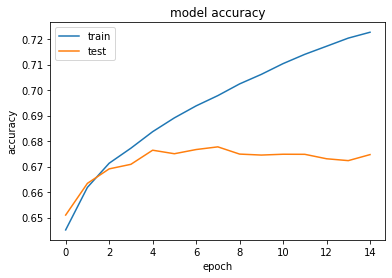

In [0]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

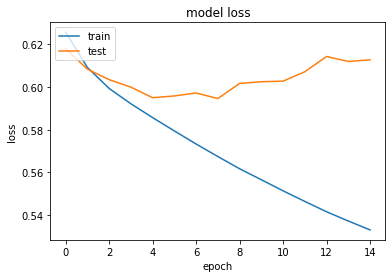

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
score = model.evaluate(x_test, y_test, verbose=1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
score

[0.6109940449522633, 0.6759146]